## Importing Libraries and Functions

In [1]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras import models
from keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.image import rgb_to_grayscale
from tensorflow import reshape
from tensorflow.image import resize_with_pad
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import numpy as np
from imgaug import augmenters as iaa
import imgaug as ia

%matplotlib inline

In [2]:
sys.path[0] = '/Users/nicksubic/Documents/flatiron/phase_1/nyc-mhtn-ds-091420-lectures/Phase_4/chest_xray/Pnuemonia-image-classification/src/modules/'
import graphs
import data

## Importing the Data

In [3]:
images = data.import_image_to_array('/../../../chest_xray/',
         dir_names = ['train', 'test', 'val'],
         sub_dir_names = ['NORMAL', 'PNEUMONIA'],
         padding=False,
         shape=(224,224), test=False, grayscale = False)

Your relative directory is good, proceeding to import files...

Loading images from train
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from test
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from val
Finished loading images from NORMAL
Finished loading images from PNEUMONIA



In [ ]:
### Splitting the train, test and validation data into just image arrays for modeling

In [4]:
X_train = np.array([i[1] for i in images['train']])  
y_train = np.array([i[2] for i in images['train']])

X_test = np.array([i[1] for i in images['test']])
y_test = np.array([i[2] for i in images['test']])

X_val = np.array([i[1] for i in images['val']])
y_val = np.array([i[2] for i in images['val']])

### Creating a simple baseline CNN model with 2 Convolution layers, 1 densely connected and no regularization

In [5]:
#baseline model- two convolution layers, maxpooling, one 32 node dense layer and the output

cnn = models.Sequential()

# Input convolution layer
cnn.add(layers.Conv2D(64, kernel_size= (3, 3), activation='relu', input_shape=(224, 224,  3)))

# Max pooling layer
cnn.add(layers.MaxPooling2D((2, 2)))

# Hidden convolution layer and pool
cnn.add(layers.Conv2D(32, kernel_size= (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))

# Output
cnn.add(layers.Dense(1, activation='sigmoid'))

# Compiling with stochastic gradient descent, optimized for accuracy
cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [6]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_val, y_val))

Epoch 1/5
105/105 [==============================] - 220s 2s/step - loss: 0.5133 - acc: 0.7483 - val_loss: 0.6489 - val_acc: 0.6250
Epoch 2/5
105/105 [==============================] - 214s 2s/step - loss: 0.3916 - acc: 0.8259 - val_loss: 0.6066 - val_acc: 0.7500
Epoch 3/5
105/105 [==============================] - 212s 2s/step - loss: 0.2979 - acc: 0.8802 - val_loss: 0.5588 - val_acc: 0.7500
Epoch 4/5
105/105 [==============================] - 202s 2s/step - loss: 0.2139 - acc: 0.9126 - val_loss: 0.3247 - val_acc: 0.9375
Epoch 5/5
105/105 [==============================] - 199s 2s/step - loss: 0.1765 - acc: 0.9314 - val_loss: 0.3170 - val_acc: 0.8750


In [42]:
results_test = cnn.evaluate(X_test, y_test)

NameError: name 'cnn' is not defined

In [5]:
# Confusion Matrix functions
def get_labels(fit_model, X, threshold):
    return [1 if x >= threshold else 0 for x in fit_model.predict(X)]
def get_false_positive(true, prediction):
    return [1 if (x == 0 and y == 1) else 0 for x,y in zip(true,prediction)]
def get_true_positive(true, prediction):
    return [1 if (x == 1 and y == 1) else 0 for x,y in zip(true,prediction)]
def get_false_negative(true, prediction):
    return [1 if (x == 1 and y == 0) else 0 for x,y in zip(true,prediction)]

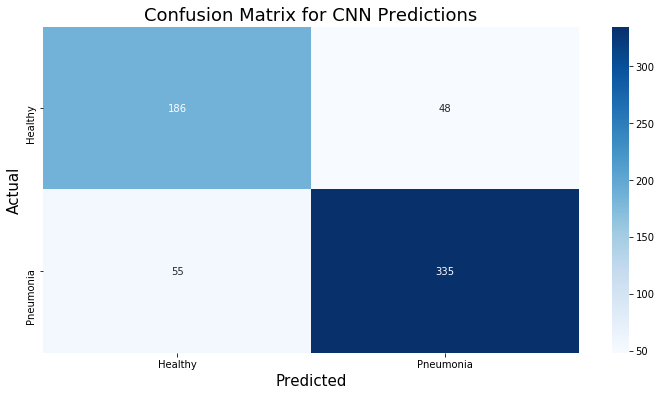

In [8]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(cnn, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

In [ ]:
## Creating a more optimized model

#### Next, we created a much more complex model. We expanded our metrics from just Accuracy to adding AUC and Recall. We changed our optimizer to Adam in order to reduce improve our learning rate. We created overlaps in our pools, added regularization layers and increased the number of graduated dense layers. We also calculated the inverse class frequency to further compensate for our class imbalance.

In [6]:
# calculate inverse 
pnue_frequency = sum(y_train)/len(y_train)
inv_pnue_frequency = 1/pnue_frequency
normal_frequency = (len(y_train)-sum(y_train))/len(y_train)
inv_normal_frequency = 1/normal_frequency
weights = {
    0: inv_normal_frequency,
    1: inv_pnue_frequency
    }

In [10]:
# Setting an early stop feature
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

rms = tf.keras.optimizers.RMSprop(learning_rate=0.1)

cnn2 = models.Sequential()
# Input convolution layers
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Overlapped pooling
cnn2.add(layers.MaxPooling2D((2, 3)))

# First hidden convolution layers and pool
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

# Second hidden convolution layers and pools
cnn2.add(layers.Conv2D(16, (6, 6), activation='relu'))
cnn2.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

# Flatten layer
cnn2.add(layers.Flatten())

# 3 Graduated densely connected layers with graduated regularization
cnn2.add(layers.Dense(64, activation='relu'))
cnn2.add(layers.Dropout(.5))
cnn2.add(layers.Dense(32, activation='relu'))
cnn2.add(layers.Dropout(.3))
cnn2.add(layers.Dense(16, activation='relu'))
cnn2.add(layers.Dropout(.1))

# Output layer
cnn2.add(layers.Dense(1, activation='sigmoid'))
cnn2.compile(loss='binary_crossentropy',
              optimizer= 'Adam',
              metrics=['acc', 'Recall', 'AUC'])

# Fitting the model with our additional class weight parameter
cnn3 = cnn2.fit(X_train, y_train,
               epochs=20,
               batch_size=50,
               validation_data = (X_val, y_val), 
               class_weight=weights,
               verbose=True,
               callbacks = callback)

Epoch 1/20
105/105 [==============================] - 427s 4s/step - loss: 1.2222 - acc: 0.5807 - recall: 0.5228 - auc: 0.7227 - val_loss: 0.4608 - val_acc: 0.8125 - val_recall: 1.0000 - val_auc: 0.9219
Epoch 2/20
105/105 [==============================] - 438s 4s/step - loss: 0.6434 - acc: 0.8804 - recall: 0.8756 - auc: 0.9409 - val_loss: 0.2902 - val_acc: 0.9375 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/20
105/105 [==============================] - 437s 4s/step - loss: 0.4434 - acc: 0.9195 - recall: 0.9159 - auc: 0.9705 - val_loss: 0.2889 - val_acc: 0.8750 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/20
105/105 [==============================] - 422s 4s/step - loss: 0.4435 - acc: 0.9212 - recall: 0.9210 - auc: 0.9702 - val_loss: 0.1533 - val_acc: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 5/20
105/105 [==============================] - 419s 4s/step - loss: 0.3565 - acc: 0.9363 - recall: 0.9339 - auc: 0.9803 - val_loss: 0.1736 - val_acc: 1.0000 - val_recall: 1.0000 - v

In [11]:
#evaluating the model on the test set

results_test2 = cnn2.evaluate(X_test, y_test)

20/20 [==============================] - 13s 639ms/step - loss: 0.9303 - acc: 0.7901 - recall: 0.9769 - auc: 0.8848


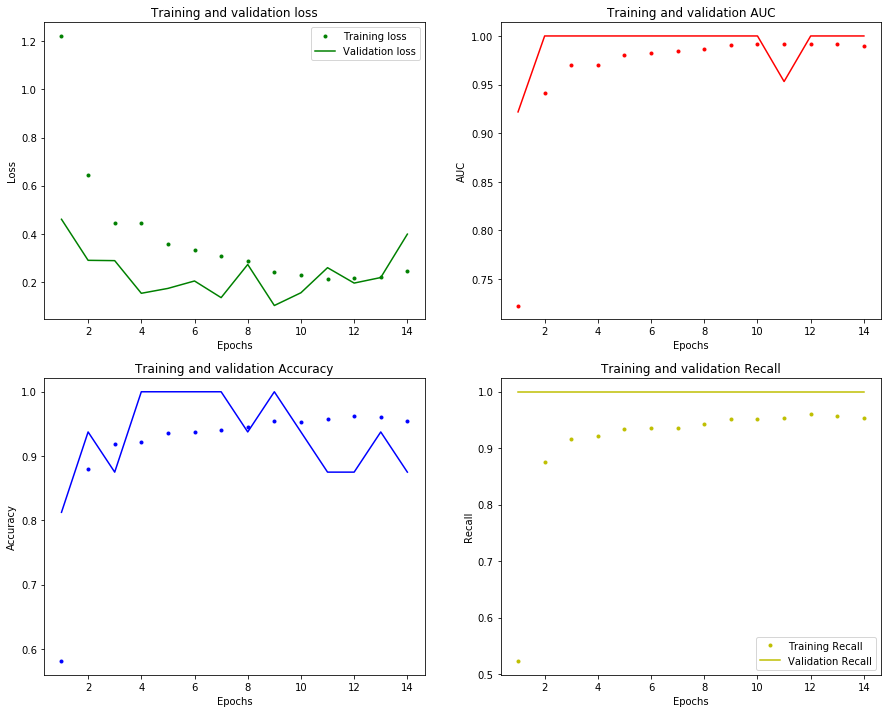

In [12]:
# Plotting the progress by epoch

graphs.plot_loss(cnn3.history)

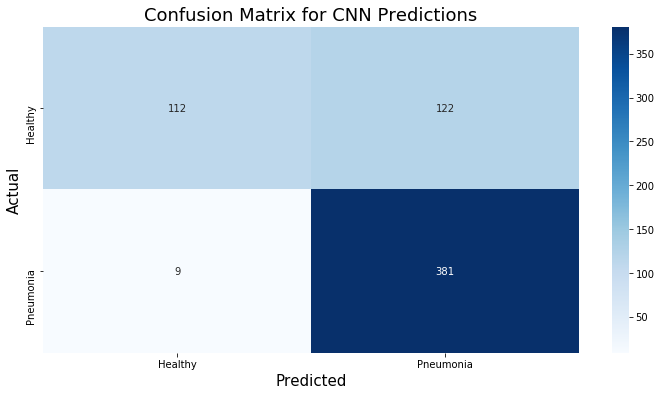

In [13]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(cnn2, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

AUC: 0.7277777777777777


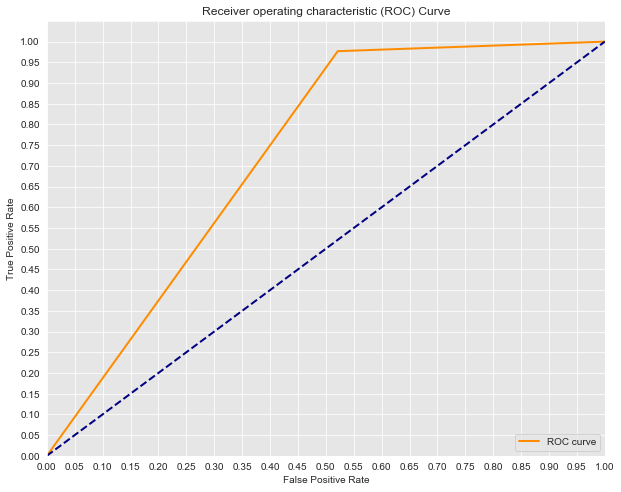

In [14]:
# Plotting the ROC curve of our predictions

predictions = get_labels(cnn2, X_test, 0.5)
graphs.plot_roc_curve(y_test, predictions)

In [ ]:
## Transfer Learning

Though our initial results are looking good, we decided to bring in some pre-trained models and try to use them in conjuction- both to get ideas about the architecture that could work the best for us and to possibly use a stacking classifier to combine a variety of models for the best possible result.

In [ ]:
### VGG16

In [ ]:
VGG16_model = VGG16(input_shape = (224, 224, 3), 
                    # Shape of our images
                    include_top = False, 
                    # Leave out the last fully connected layer
                    weights = 'imagenet')

for layer in VGG16_model.layers:
    layer.trainable = False
#making the existing layers untrainable in order to preserve them

# Flatten the output layer to 1 dimension
x = layers.Flatten()(VGG16_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a second fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Dropout with a rate of 0.3
x = layers.Dropout(.3)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(VGG16_model.input, x)

vggmodel.compile(optimizer = 'Adam', 
              loss = 'binary_crossentropy',
              metrics = ['acc', 'Recall', 'AUC'])

vgghist = vggmodel.fit(X_train, y_train, 
                       validation_data = (X_val, y_val), 
                       epochs = 10, 
                       batch_size=50, 
                       class_weight=weights, 
                       callbacks= callback)

In [ ]:
# evaluating the model on the test set

results_test3 = vggmodel.evaluate(X_test, y_test)

In [ ]:
#Plotting loss by epoch

graphs.plot_loss(vgghist.history)

In [ ]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(vggmodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

In [ ]:
# Plotting the ROC curve of our predictions

predictions = get_labels(vggmodel, X_test, 0.5)
graphs.plot_roc_curve(y_test, predictions)

In [ ]:
### DenseNet121

In [37]:
densebase = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='Max',
    classes=2,)

for layer in densebase.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Flatten the output layer to 1 dimension
a = layers.Flatten()(densebase.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
a = layers.Dense(512, activation='relu')(a)

# Add a dropout rate of 0.5
a = layers.Dropout(0.5)(a)

# Add a second fully connected layer with 256 hidden units and ReLU activation
a = layers.Dense(256, activation='relu')(a)

a = layers.Dropout(.3)(a)
# Add a final sigmoid layer for classification
a = layers.Dense(1, activation='sigmoid')(a)

densemodel = tf.keras.models.Model(densebase.input, a)

densemodel.compile(optimizer = 'sgd', loss = 'binary_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

densehist = densemodel.fit(
                      X_train, y_train, 
                      validation_data = (X_val, y_val), 
                      epochs = 25, 
                      batch_size=25, 
                      class_weight=weights)

Epoch 1/25
209/209 [==============================] - 340s 2s/step - loss: 1.9098 - acc: 0.8439 - recall: 0.8423 - auc: 0.9121 - val_loss: 0.1492 - val_acc: 0.9375 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/25
209/209 [==============================] - 334s 2s/step - loss: 0.3596 - acc: 0.9283 - recall: 0.9290 - auc: 0.9802 - val_loss: 0.1854 - val_acc: 0.9375 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/25
209/209 [==============================] - 333s 2s/step - loss: 0.2917 - acc: 0.9425 - recall: 0.9440 - auc: 0.9865 - val_loss: 0.1000 - val_acc: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/25
209/209 [==============================] - 331s 2s/step - loss: 0.2241 - acc: 0.9519 - recall: 0.9461 - auc: 0.9917 - val_loss: 0.0762 - val_acc: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 5/25
209/209 [==============================] - 331s 2s/step - loss: 0.1984 - acc: 0.9523 - recall: 0.9461 - auc: 0.9932 - val_loss: 0.1628 - val_acc: 0.9375 - val_recall: 1.0000 - v

In [38]:
# evaluating the model on the test set

results_test4 = densemodel.evaluate(X_test, y_test)

20/20 [==============================] - 36s 2s/step - loss: 1.0055 - acc: 0.8125 - recall: 0.9974 - auc: 0.9059


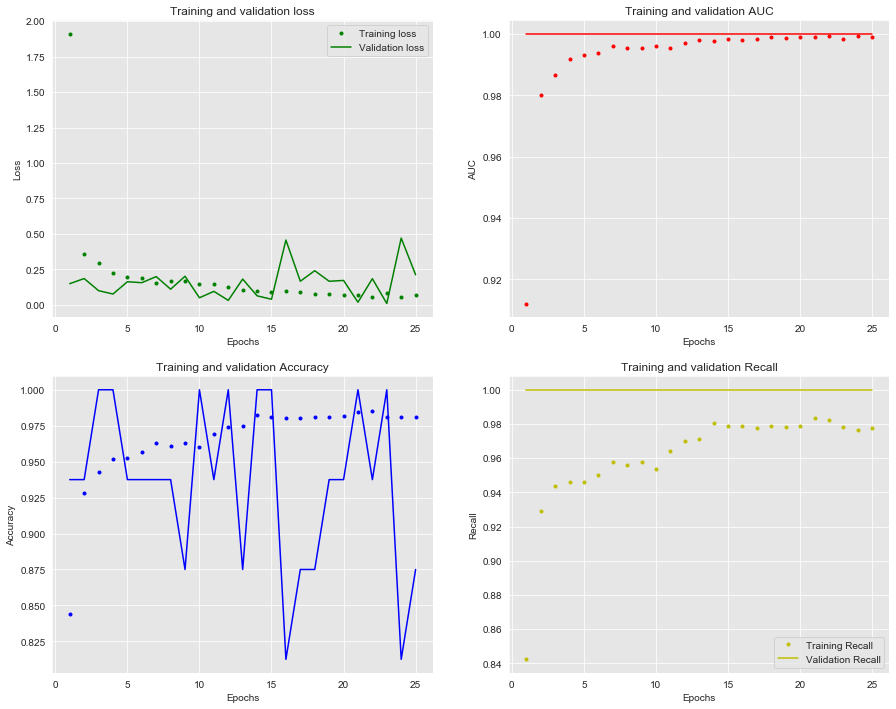

In [39]:
# Plotting loss by epoch

graphs.plot_loss(densehist.history)

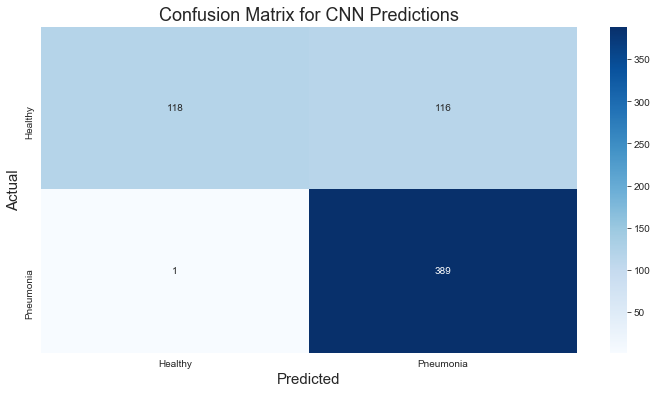

In [40]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(densemodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

AUC: 0.7508547008547009


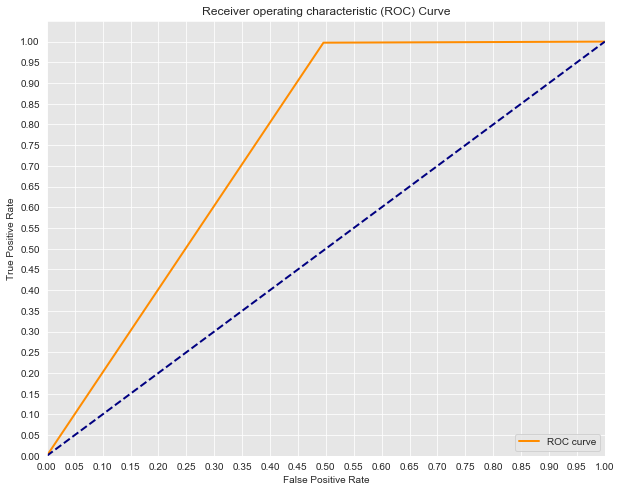

In [41]:
# Plotting the ROC curve of our predictions

predictions = get_labels(densemodel, X_test, 0.5)
graphs.plot_roc_curve(y_test, predictions)

In [ ]:
### MobileNetV2

In [109]:
mobile = tf.keras.applications.MobileNetV2(
                input_shape=(224, 224, 3), 
                alpha=1.0, 
                include_top=False, 
                weights='imagenet',
                input_tensor=None, 
                pooling='max', 
                classes=2)

for layer in mobile.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Flatten the output layer to 1 dimension
a = layers.Flatten()(mobile.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
a = layers.Dense(512, activation='relu')(a)

# Add a dropout rate of 0.5
a = layers.Dropout(0.5)(a)

# Add a second fully connected layer with 256 hidden units and ReLU activation
a = layers.Dense(256, activation='relu')(a)

a = layers.Dropout(.3)(a)
# Add a final sigmoid layer for classification
a = layers.Dense(1, activation='sigmoid')(a)

mobilemodel = tf.keras.models.Model(mobile.input, a)

mobilemodel.compile(optimizer = 'Adam', loss = 'binary_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

mobilehist = mobilemodel.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20, batch_size=25, class_weight=weights)

Epoch 1/20
209/209 [==============================] - 101s 483ms/step - loss: 1.3130 - acc: 0.8612 - recall: 0.8627 - auc: 0.9164 - val_loss: 0.1503 - val_acc: 0.9375 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/20
209/209 [==============================] - 101s 485ms/step - loss: 0.4169 - acc: 0.9258 - recall: 0.9226 - auc: 0.9741 - val_loss: 0.2807 - val_acc: 0.8750 - val_recall: 0.7500 - val_auc: 1.0000
Epoch 3/20
209/209 [==============================] - 104s 496ms/step - loss: 0.3239 - acc: 0.9413 - recall: 0.9360 - auc: 0.9831 - val_loss: 0.1301 - val_acc: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/20
209/209 [==============================] - 105s 503ms/step - loss: 0.3177 - acc: 0.9333 - recall: 0.9311 - auc: 0.9845 - val_loss: 0.1294 - val_acc: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 5/20
209/209 [==============================] - 101s 482ms/step - loss: 0.2889 - acc: 0.9479 - recall: 0.9440 - auc: 0.9857 - val_loss: 0.3821 - val_acc: 0.6875 - val_rec

In [110]:
mobile_test = mobilemodel.evaluate(X_test, y_test)

20/20 [==============================] - 14s 683ms/step - loss: 0.3869 - acc: 0.8862 - recall: 0.9795 - auc: 0.9528


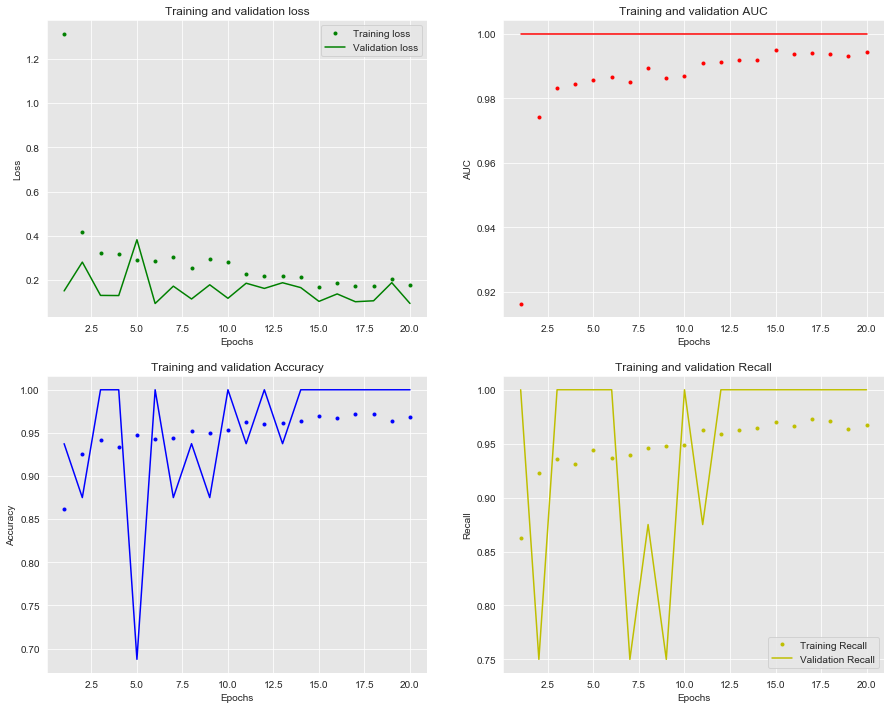

In [111]:
# Plotting loss by epoch

graphs.plot_loss(mobilehist.history)

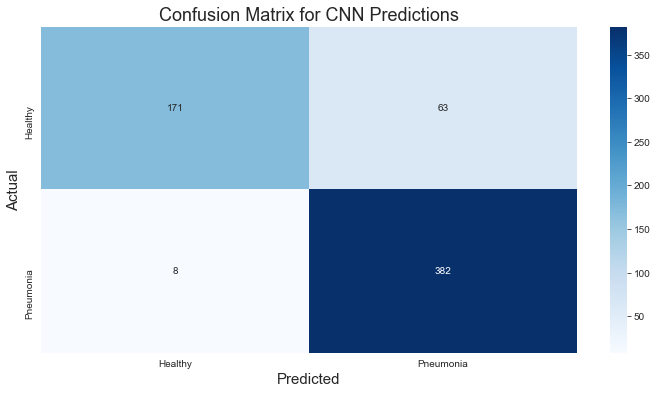

In [112]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(mobilemodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

AUC: 0.8551282051282052


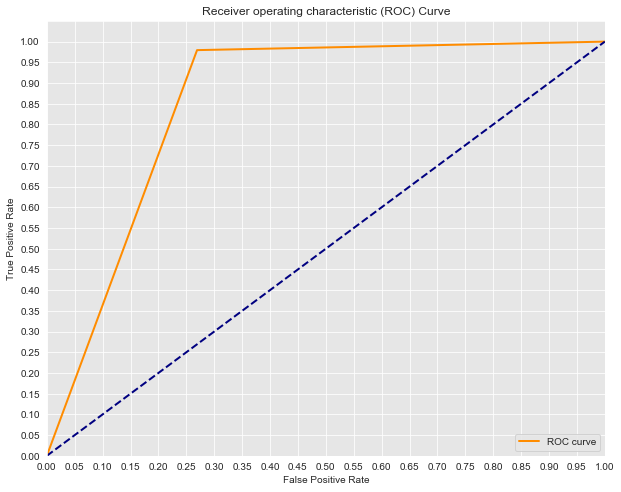

In [113]:
# Plotting the ROC curve of our predictions

predictions = get_labels(mobilemodel, X_test, 0.5)
graphs.plot_roc_curve(y_test, predictions)

In [30]:
### Creating a stacked classifier

In [31]:
from scipy import stats

def stacked_classifier(list_of_models,
                       X_test,
                       y_test,
                       model_input_shape=None, 
                       model_weights=None,
                       threshold=0.5,
                       soft_voting=True):
    """
    given a list of classifiers, returns a hard or soft voting array of predictions
    """
    # instantiate a prediction matrix
    m = len(X_test) # matrix rows
    n = len(list_of_models) # matrix columns
    prediction_matrix = np.ones((m,n))
    # update predictions matrix
    for i in range(0,n):
        print(f"Generating predictions for model {i+1}")
        model = list_of_models[i]
        p = model.predict(X_test)
        prediction_matrix[:,i] *= p.ravel()
        print(f"Finished prediction on model {i+1}")
    # Adjust the weights of each prediction
    if model_weights:
        print("Adjusting weights of the classifier's predictins", end="/n/n")
        for i, weight in enumerate(model_weights):
            prediction_matrix[:,i] *= model_weights[weight]
    if not soft_voting:
        print("Returning hard voting predictions")
        preditions =  prediction_matrix > threshold
        return stats.mode(predictions, axis=1)
    else:
        print("Returning soft voting predictions")
        predictions = np.mean(prediction_matrix, axis=1)
        return predictions > threshold

In [108]:
ensemble_preds = stacked_classifier([mobilemodel, vggmodel],
                       X_test,
                       y_test,
                       model_input_shape=(224,224,3), 
                       model_weights=None,
                       threshold=0.5,
                       soft_voting=True)

Generating predictions for model 1


ValueError: operands could not be broadcast together with shapes (624,) (1872,) (624,) 

In [ ]:
graphs.plot_cmatrix(y_test,ensemble_preds)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score

print(accuracy_score(y_test, ensemble_preds))
print(recall_score(y_test, ensemble_preds))

In [53]:
#saving models
from datetime import datetime
today = str(datetime.today()).split()[0]
directory = "../../src/models/"
model_id = "vgg"
filename = directory+today+model_id+".HDF5"

vggmodel.save(filename)

INFO:tensorflow:Assets written to: ../../src/models/2020-12-06vgg.HDF5/assets


In [54]:
model_id = 'homemade'
filename = directory+today+model_id+'.HDF5'

cnn2.save(filename)

INFO:tensorflow:Assets written to: ../../src/models/2020-12-06homemade.HDF5/assets


In [55]:
model_id = 'mobilenetv2'
filename = directory+today+model_id+'.HDF5'

mobilemodel.save(filename)

INFO:tensorflow:Assets written to: ../../src/models/2020-12-06mobilenetv2.HDF5/assets


In [60]:
images['train'][2200][0].find('bacteria')

10

In [89]:
y_train1 = []
for i in range(0, len(images['train'])):
    if images['train'][i][2] == 0:
        y_train1.append(0)
    elif images['train'][i][2] != 0 and images['train'][i][0].find('bacteria') != -1:
        y_train1.append(1)
    elif images['train'][i][2] != 0 and images['train'][i][0].find('virus') != -1:
        y_train1.append(2)
y_train1 = np.array(y_train1)

In [69]:
y_test1 = []
for i in range(0, len(images['test'])):
    if images['test'][i][2] == 0:
        y_test1.append(0)
    elif images['test'][i][2] != 0 and images['test'][i][0].find('bacteria') != -1:
        y_test1.append(1)
    elif images['test'][i][2] != 0 and images['test'][i][0].find('virus') != -1:
        y_test1.append(2)

In [88]:
y_val1 = []
for i in range(0, len(images['val'])):
    if images['val'][i][2] == 0:
        y_val1.append(0)
    elif images['val'][i][2] != 0 and images['val'][i][0].find('bacteria') != -1:
        y_val1.append(1)
    elif images['val'][i][2] != 0 and images['val'][i][0].find('virus') != -1:
        y_val1.append(2)
y_val1 = np.array(y_val1)

In [82]:
np.array(y_train1)

array([0, 0, 0, ..., 2, 2, 2])

In [104]:
mobile1 = tf.keras.applications.MobileNetV2(
                input_shape=(224, 224, 3), 
                include_top=False, 
                weights='imagenet',
                input_tensor=None, 
                pooling='max', 
                classes=3)

for layer in mobile.layers:
    layer.trainable = False

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# # Flatten the output layer to 1 dimension
a = layers.Flatten()(mobile1.output)

# # # Add a fully connected layer with 512 hidden units and ReLU activation
# # a = layers.Dense(512, activation='relu')(a)

# # # Add a dropout rate of 0.5
# # a = layers.Dropout(0.5)(a)

# # # Add a second fully connected layer with 256 hidden units and ReLU activation
# # a = layers.Dense(256, activation='relu')(a)

# # a = layers.Dropout(.3)(a)
# # Add a final sigmoid layer for classification
a = layers.Dense(units= 3, activation='softmax')(a)

mobilemodel = tf.keras.models.Model(mobile1.input, a)

mobilemodel.compile(optimizer = 'Adam', loss = 'categorical_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

mobilehist = mobilemodel.fit(X_train, y_train1, validation_data = (X_val, y_val1), epochs = 20, batch_size=25)

Epoch 1/20


ValueError: in user code:

    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/nicksubic/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible
